# Weighting of friends in agent-based models of social support


_Sheridan Kates, 03.06.2022_


<b><i>[This notebook by Joël Foramitti](https://github.com/JoelForamitti/ses_modeling_course/blob/main/05_Social_Support_ABM.ipynb) introduced a simple agent-based model to explore the propagation of social support through a population. The purpose of this notebook is to try to adapt it to model the effect of different levels of support among the popular agents in the model (i.e. those with more than average friend connections), to model how that might affect successful outcomes of support for a cause. Edits from the original code are called out in comments marked `(sheridan)`, and additions to the text are in bold italics (like this one).</i></b>


In [8]:
import agentpy as ap
import networkx as nx
import seaborn as sns
import os

sns.set_theme()


The agents of the model have one variable `support` which indicates their support for a particular cause.

At every time-step, an agent interacts with their friends as well as some random encounters.

The higher the perceived support amongst their encounters, the higher the likelihood that the agent will also support the cause.


In [9]:
class Individual(ap.Agent):
    def setup(self):

        # Initiate a variable support
        # 0 indicates no support, 1 indicates support
        self.support = 0

    def adapt_support(self):

        # Perceive average support amongst friends and random encounters
        random_encounters = self.model.agents.random(self.p.random_encounters)
        all_encounters = self.friends + random_encounters
        perceived_support = sum(all_encounters.support) / len(all_encounters)

        # Adapt own support based on random chance and perceived support
        random_draw = self.model.random.random()  # Draw between 0 and 1
        self.support = 1 if random_draw < perceived_support else 0


At the start of the simulation, the model initiates a population of agents, defines a random network of friendships between these agents, and chooses a random share of agents to be the initial supporters of the cause.

<b><i>The major change in the model logic is here. Instead of assigning the support randomly across all agents in the model, we now use the `popular_agent_support_multiplier` to alter now much support there is among the popular agents (i.e. those with the most connections) for the cause, while still ensuring the same amount of support for the cause overall.</i></b>

At every simulation step, agents change their support and the share of supporters is recorded.

At the end of the model, the cause is designated a success if all agents support it.


In [10]:
class SupportModel(ap.Model):
    def setup(self):

        # Initiating agents
        self.agents = ap.AgentList(self, self.p.n_agents, Individual)

        # Setting up friendships
        graph = nx.watts_strogatz_graph(
            self.p.n_agents, self.p.n_friends, self.p.network_randomness
        )
        self.network = self.agents.network = ap.Network(self, graph=graph)
        self.network.add_agents(self.agents, self.network.nodes)
        for a in self.agents:
            a.friends = self.network.neighbors(a).to_list()

        # Setting up initial supporters
        initial_supporters = int(self.p.initial_support * self.p.n_agents)

        # (sheridan) This is the core of how we model higher support amoung popular agents. On average, everyone
        # in the model has n_friends - but the Watts Strogatz graph randomises friend connections such that some
        # people have more friends than others.
        # We find those popular agents (i.e. those that have more than the initially-specified number of friends),
        # and make them more likely than the average to support the case, based on the popular_agent_support_multiplier.

        popular_agents = self.agents.select(
            list(map(lambda a: len(a.friends) > self.p.n_friends, self.agents))
        )

        # (sheridan) The regular agents are just those that are in the agent list, but aren't popular
        regular_agents = self.agents.select(
            list(map(lambda a: a not in popular_agents, self.agents))
        )

        # (sheridan) In order to make sure that the popular_agent_support_multiplier doesn't take the number of popular supporters
        # greater than the actual number of popular_agents that exists, we clamp the number of popular supporters down to the
        # length of the popular agents list if it ends up higher than that.
        initial_popular_supporters = int(
            min(
                (self.p.initial_support * self.p.popular_agent_support_multiplier)
                * len(popular_agents),
                len(popular_agents),
            )
        )
        # (sheridan) So that we're not influencing the amount of support overall, we need to make sure that the overall initial_support
        # level is whatever was passed in. So we subtract the number of supporting popular agents from the overall required supporter count.
        initial_regular_supporters = initial_supporters - initial_popular_supporters

        # Randomly assign the calculated number of supporters in each of the popular and regular sets.
        for popular_agent in popular_agents.random(initial_popular_supporters):
            popular_agent.support = 1
        for regular_agent in regular_agents.random(initial_regular_supporters):
            regular_agent.support = 1

    def step(self):

        # Let every agent adapt their support
        self.agents.adapt_support()

    def update(self):

        # Record the share of supporters at each time-step
        self.supporter_share = sum(self.agents.support) / self.p.n_agents
        self.record("supporter_share")

    def end(self):

        # Report the success of the social movement
        # at the end of the simulation

        self.success = 1 if self.supporter_share == 1 else 0
        self.model.report("success")


For the generation of the network graph, we will use the [Watts-Strogatz model](https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model). This is an algorithm that generates a regular network were every agent will have the same amount of connections, and then introduces a certain amount of randomness to change some of these connections. A network where most agents are not neighbors, but where it is easy to reach every other agent in a small number of steps, is called a [small-world network](https://en.wikipedia.org/wiki/Small-world_network).

<img src="networks.png" alt="drawing" width="600"/>


## A single-run simulation


In [11]:
parameters = {
    "steps": 100,
    "n_agents": 100,
    "n_friends": 2,
    "network_randomness": 0.5,
    "initial_support": 0.5,
    "random_encounters": 1,
    "popular_agent_support_multiplier": 2,
}


In [12]:
model = SupportModel(parameters)
results = model.run()
success = "Yes" if model.success else "No"
print(f"Success: {success}")


Completed: 100 steps
Run time: 0:00:00.161459
Simulation finished
Success: Yes


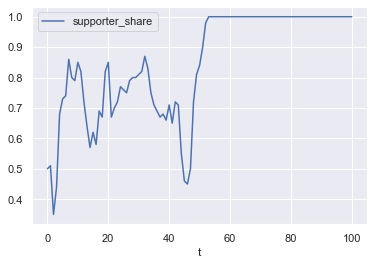

In [13]:
ax = results.variables.SupportModel.plot()


## A multi-run experiment


In [14]:
# (sheridan) here we're now keeping the initial support constant at an average of 0.5 (where the previous model showed approximately
# a 50% chance of success) and varying the popular_agent_support_multiplier - i.e. how much more or less the popular agents support 
# the cause compared to the average
sample_parameters = {
    "steps": 100,
    "n_agents": 100,
    "n_friends": 2,
    "network_randomness": 0.5,
    "initial_support": 0.5,
    "popular_agent_support_multiplier": ap.Range(0, 4),
    "random_encounters": 1,
}


In [15]:
sample = ap.Sample(sample_parameters, n=50)
exp = ap.Experiment(SupportModel, sample, iterations=50)
# (sheridan) add parallel processing as the experiments now all take longer. use half of available cores.
cores_for_exp = int(os.cpu_count() / 2)
results = exp.run(n_jobs=cores_for_exp, verbose=1)


Scheduled runs: 2500


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 2500 out of 2500 | elapsed:  2.1min finished


Experiment finished
Run time: 0:02:04.737254


Text(0, 0.5, 'Chances of success')

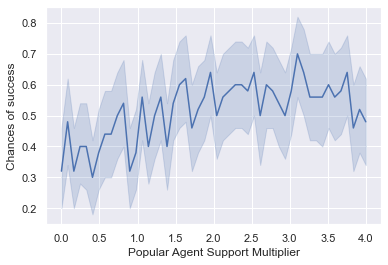

In [16]:
ax = sns.lineplot(
    data=results.arrange_reporters(), x="popular_agent_support_multiplier", y="success"
)
ax.set_xlabel("Popular Agent Support Multiplier")
ax.set_ylabel("Chances of success")


## Analysis of outcome
We can see from the multi-run experiment that the `popular_agent_support_boost` factor does indeed have a proportional impact on chance of success, up until a cap of about 2.0 support boost. This is expected, as at this level we are taking the initial support level (0.5) and multiplying it by 2, so the support level in the popular agents is 100% and you can't increase beyond that level. In the appendix below we run the experiment again just between 0 and 2 to zoom in on that effect, and add a trend line to the data to show this relationship even more clearly.

Additionally the model shows that if the popular agents have less support than the `initial_support` level, the changes of success drop down below the expectation, which also follows what we might expect.

This model suggests that it might be important to target the people with a lot of connections in a network, as their impact will be outsized on the support propagating to other members of the network.


## Appendix
Here I re-run the multi-run experiment with a `popular_agent_support_multiplier` range of 0 to 2, and add a trend line to more clearly show the relationship between this measure of popular agents' support levels and success.

In [17]:
sample_parameters_smaller_window = {
    "steps": 100,
    "n_agents": 100,
    "n_friends": 2,
    "network_randomness": 0.5,
    "initial_support": 0.5,
    "popular_agent_support_multiplier": ap.Range(0, 2),
    "random_encounters": 1,
}
sample_smaller_window = ap.Sample(sample_parameters_smaller_window, n=50)
exp_smaller_window = ap.Experiment(SupportModel, sample_smaller_window, iterations=50)
# add parallel processing as the experiments now all take longer. use half of available cores.
cores_for_exp = int(os.cpu_count() / 2)
results_smaller_window = exp_smaller_window.run(n_jobs=cores_for_exp, verbose=1)


Scheduled runs: 2500


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   56.2s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 2500 out of 2500 | elapsed:  2.0min finished


Experiment finished
Run time: 0:02:00.577981


Text(0, 0.5, 'Chances of success')

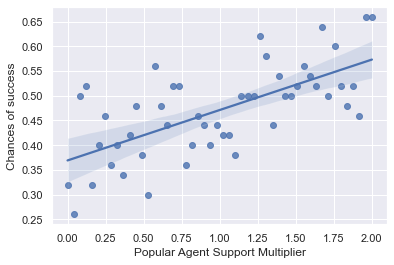

In [18]:
df = results_smaller_window.arrange_reporters()
grouped_data = (
    df[["popular_agent_support_multiplier", "success"]]
    .groupby("popular_agent_support_multiplier")
    .mean()
)
ax = sns.regplot(data=grouped_data, x=grouped_data.index, y="success")
ax.set_xlabel("Popular Agent Support Multiplier")
ax.set_ylabel("Chances of success")
